# Gradient Based Attribution for Deep Networks
We will look at some attribution methods for explaining deep networks. Here we will consider **Gradient**, **Smoothgrad**, and **Integrated Gradients** attributions. These methods will be useful as a setup for more sophisticated tasks (Image Captioning) and the NLP domain.

### Gradient Map
To start, let's look at the simple **Gradient** map. 
Let's says we have a deep network, $f$, that maps inputs $x \in \mathbb{R^n}$ to outputs $ y \in \mathbb{R}^c}$. Here $c$ is the number of output classes if we had, say, a classification model. Consider a model trained on the ImageNet dataset for object recognition (1000 classes). Now let's say we are given an input image that is a *Junco Bird*, and the top-1 classification for the model corresponds to class 14, which happens to be the correct class. This means the largest logit score amongst the 1000 classes was the Junco bird class. We can ask the question: **how much will the output logit for the Junco bird class change if we change a pixel by a tiny infinitesimal amount?**  This is the question that the **Gradient** map answers. It is corresponds to $\frac{d(f_i(x))}{dx}$. The output of the the per-class gradient is a vector that is the same size as the input, and for which each dimension correponds to the sensitivity of the class logit wrt that dimension. 

Several other methods are built on this simple Gradient Map. Despite its simplicity, the gradient map has a few downsides (saturation etc). To overcome these limitations, several additional methods have been proposed to correct this. 

### SmoothGrad
One such method is SmoothGrad. Smoothgrad corresponds to the average of the gradient for noisy examples.

### Integrated Gradients
Integrated Gradients is another attribution method that satisfies additional desirable properties that the simple gradient method does not satisfy. Overall, integrated gradients constructs a path-integral of the gradients from a baseline image to the original image. We can think of this as summing of the simple gradient over a linear interpolation from the baseline to the original image. 

The field of DNN attribution is vast, and the above methods constitute a small portion of the set of methods in this field.


In [0]:
# Import basic libraries needed for the exercise (numpy, matplotlib, and torch)
import sys
import random
import numpy as np
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torch.utils import data
from torch.autograd import Variable
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from PIL import Image
import io

# urllib python2 v. python3 hack.
if sys.version_info[0] == 3:
    from urllib.request import urlopen
else:
    from urllib import urlopen
import json

%matplotlib inline

In [0]:
# Here are the urls to sample images that we will use in this lab.
imgurls = ["https://raw.githubusercontent.com/SIDN-IAP/local-decision/master/demoimages/ILSVRC2012_val_00015410.JPEG",
           "https://raw.githubusercontent.com/SIDN-IAP/local-decision/master/demoimages/n02814860_87.JPEG",
           "https://raw.githubusercontent.com/SIDN-IAP/local-decision/master/demoimages/ILSVRC2012_val_00032239.JPEG"]
classes = ['Junco Bird', 'Light House/Beacon', 'Wheaton Terrier']
labeljsonfile = "https://s3.amazonaws.com/mlpipes/pytorch-quick-start/labels.json"
fdjson = urlopen(labeljsonfile).read()
classlabelsdict = json.loads(fdjson)


In [0]:
# resize to (224, 224) as well. 
# this is the VGG-16 input size.
img_array = []
for imgfile in imgurls:
  fd = urlopen(imgfile).read()
  image_file = io.BytesIO(fd)
  img_array.append(Image.open(image_file).resize((224, 224)))

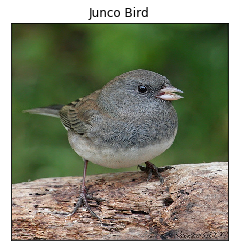

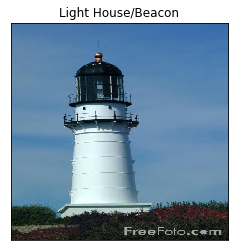

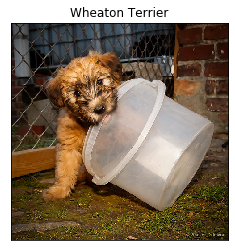

In [80]:
# let's plot these images
for i, img in enumerate(img_array):
  plt.figure()
  plt.imshow(img)
  plt.title(classes[i])
  plt.xticks([])
  plt.yticks([])

In [0]:
# Now Let's load a VGG pretrain model
model = torch.hub.load('pytorch/vision:v0.5.0', 'vgg16', pretrained=True)
model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

([], <a list of 0 Text yticklabel objects>)

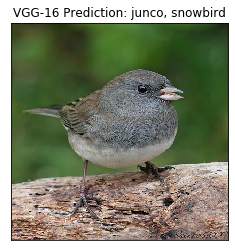

In [0]:
# We will preprocess thess images for the VGG-16 model. 
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor_list = [preprocess(img) for img in img_array]

## Let's get the model prediction on a single example.
img_index = 0
with torch.no_grad():
  output = model(input_tensor_list[img_index].unsqueeze(0))
label = classlabelsdict[str(output.argmax().item())]
plt.imshow(img_array[img_index])
plt.title("VGG-16 Prediction: " + label)
plt.xticks([])
plt.yticks([])

Let's create a class to for the attributions. We've implemented the simple
Gradient and SmoothGrad methods. You'll be coming back to fill in the
integrated gradient methods later.

In [0]:
class attributions(object):
  def __init__(self, model):
    self.model = model # model to be explained.
    self.gradients = None # hold gradients. 
    self.model.eval() # we will put the model in eval mode.
    self.hook_layers() # init the hook function for gradient.

  def hook_layers(self):
    def hook_function(module, grad_in, grad_out):
        self.gradients = grad_in[0]
    # Register hook to the first layer
    first_layer = list(self.model.features._modules.items())[0][1]
    first_layer.register_backward_hook(hook_function)


  def saliency(self, input, target_class):
    """Get the simple saliency map."""
    input.requires_grad_()
    output = self.model(input)
    self.model.zero_grad()
    one_hot_output = torch.FloatTensor(1, output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    output.backward(gradient=one_hot_output)
    return self.gradients.data.numpy()[0]

  def smoothgrad(self,
                 input,
                 target_class,
                 noise_mean=0.0,
                 noise_std_spread=0.15,
                 nsamples=25):
    """Compute the smoothgrad map. 
    
      target_class: this is the class to 'explain'
      noise_mean: mean of the gaussian noise to be added to input.
      noise_std_spread: determines for the std of the noise is.
      nsample: number of samples to use for estimating the average.
    """
    # initialize output map to zeros.
    output = np.zeros(input.size()[1:]) 

    # calculate the std
    maxinput = np.max(input.data.numpy())
    mininput = np.min(input.data.numpy())
    stdev = noise_std_spread * (maxinput - mininput)

    # get gradient of noisy examples.
    for x in range(nsamples):
      # Generate noise
      noise = Variable(input.data.new(input.size()).normal_(noise_mean, stdev**2))
      # Add noise to the image
      noisy_img = input + noise
      # Calculate gradients
      saliency = self.saliency(noisy_img, target_class)
      # Add gradients to smooth_grad
      output = output + saliency
    return output / nsamples
  
  def integrated_gradients(self,
                           input,
                           target_class,
                           xsteps):
    """Implement Integrated Gradients here."""
    pass

#### Here are are few functions to help visualize the attributions.



In [0]:
# some visualization functions
# image normalization functions
def normalize_image(x):
  """ Normalizes an input array to 0 - 1 range. Useful for raw attributions."""
  x = np.array(x).astype(np.float32)
  x_min = x.min()
  x_max = x.max()
  x_norm = (x - x_min) / (x_max - x_min)
  return x_norm

def grayscalenorm(img, percentile=99):
  r"""Returns a 3D tensor as a grayscale 2D tensor.
  This method sums a 3D tensor across the absolute value of axis=2, and then
  clips values at a given percentile.
  """
  assert len(img.shape)==3

  img2d = np.sum(np.abs(img), axis=2)
  vmax = np.percentile(img2d, percentile)
  vmin = np.min(img2d)
  return np.clip((img2d - vmin) / (vmax - vmin), 0, 1)


def posnegnorm(img, percentile=99):
  r"""Returns a 3D tensor as a grayscale 2D tensor.
  This method sums a 3D tensor across the absolute value of axis=2, and then
  clips values at a given percentile.
  """
  assert len(img.shape)==3

  img2d = np.sum(img, axis=2)
  span = abs(np.percentile(img2d, percentile))
  vmax = -span
  vmin = span
  return np.clip((img2d - vmin) / (vmax - vmin), -1, 1)

### Now let's get **Gradient** attributions for an example image.





In [0]:
vggsaliency = attributions(model) #instantiate the attribution object
img_index = 0 # for the bird image.
target = 13 # target class to computer gradient wrt.
grad = vggsaliency.saliency(input_tensor_list[img_index].unsqueeze(0), target)

In [0]:
# now, we will visualize the saliency maps. 
grad = np.transpose(grad, (1, 2, 0)) # we need to transpose for visualization

# now we normalize the gradient attributions.
gradnorm3d = normalize_image(grad)
diverg2d = posnegnorm(grad)
absnorm2d = grayscalenorm(grad)

([], <a list of 0 Text yticklabel objects>)

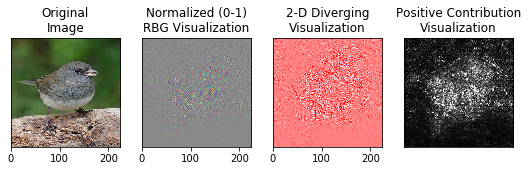

In [0]:
# plot all of the different attributions and the input as well.
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
axs[0].imshow(img_array[img_index])
axs[1].imshow(gradnorm3d, vmin=1.0, vmax=0.0, norm=None)
axs[2].imshow(diverg, vmin=-1.0, vmax=1.0, norm=None, cmap='bwr')
axs[3].imshow(absnorm2d, vmin=0.0, vmax=1.0, norm=None, cmap='gray')


axs[0].set_title("Original\nImage")
axs[1].set_title("Normalized (0-1)\nRBG Visualization")
axs[2].set_title("2-D Diverging\nVisualization")
axs[3].set_title("Positive Contribution\nVisualization")
plt.xticks([])
plt.yticks([])

### Let's Consider **SmoothGrad**

In [0]:
# might take a while
sgrad = vggsaliency.smoothgrad(input_tensor_list[img_index].unsqueeze(0), target, nsamples=50)

In [0]:
# now, we will visualize the saliency maps. 
sgrad = np.transpose(sgrad, (1, 2, 0)) # we need to transpose for visualization

# now we normalize the gradient attributions.
sgradnorm3d = normalize_image(sgrad)
sdiverg2d = posnegnorm(sgrad)
sabsnorm2d = grayscalenorm(sgrad)

([], <a list of 0 Text yticklabel objects>)

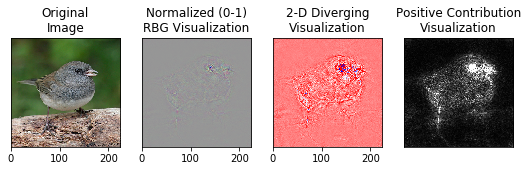

In [0]:
# plot all of the different attributions and the input as well.
fig, axs = plt.subplots(1, 4, figsize=(9, 3), sharey=True)
axs[0].imshow(img_array[img_index])
axs[1].imshow(sgradnorm3d, vmin=1.0, vmax=0.0, norm=None)
axs[2].imshow(sdiverg2d, vmin=-1.0, vmax=1.0, norm=None, cmap='bwr')
axs[3].imshow(sabsnorm2d, vmin=0.0, vmax=1.0, norm=None, cmap='gray')


axs[0].set_title("Original\nImage")
axs[1].set_title("Normalized (0-1)\nRBG Visualization")
axs[2].set_title("2-D Diverging\nVisualization")
axs[3].set_title("Positive Contribution\nVisualization")
plt.xticks([])
plt.yticks([])

## Now try out the other 2 examples and visualize both the gradient and SmoothGrad outputs. 

## Implement Integrated Gradients and visualize the integrated gradients attributions for all 3 examples. 